In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.6 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from catboost import CatBoostClassifier, Pool

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'macro')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, macro f1_score: {3:.4f}'.format(accuracy, precision, recall, f1))

In [28]:
train_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/train_smote.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/val.csv')
valid_df.drop(['ID'], axis=1, inplace=True)
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_df.drop(['ID'], axis=1, inplace=True)
print(train_df.shape, valid_df.shape, test_df.shape)
print('train_smote data 이상치 비율:', train_df[train_df['Class'] == 1].shape[0] / train_df.shape[0])
print('valid data 이상치 비율:', valid_df[valid_df['Class'] == 1].shape[0] / valid_df.shape[0])

(227500, 31) (28462, 31) (142503, 30)
train_smote data 이상치 비율: 0.5
valid data 이상치 비율: 0.0010540369615627855


In [29]:
X_train, y_train, X_valid, y_valid = train_df.iloc[:, :-1], train_df['Class'], valid_df.iloc[:, :-1], valid_df['Class']

## 단일 모델(adaboost, xgboost, lgbm, catboost) 최적 파라미터 사용

In [11]:
base_model = DecisionTreeClassifier(max_depth=5, random_state=0)
ada_clf = AdaBoostClassifier(base_estimator = base_model, n_estimators=100, random_state=42)
lgbm_clf = LGBMClassifier(learning_rate = 0.01)
xgb_clf = XGBClassifier(n_estimators=2000, max_depth=6, subsample=0.5, learning_rate=0.1, objective='binary:logistic', tree_method='gpu_hist', gpu_id=0, random_state=0)
cat_clf = CatBoostClassifier(iterations=1000, task_type='GPU', learning_rate=0.01, loss_function='CrossEntropy', random_state=0)

## Hard Voting

In [ ]:
vo_clf = VotingClassifier(estimators=[('ADA', ada_clf), ('LGBM', lgbm_clf), ('XGB', xgb_clf)], voting='hard')
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('ADA',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                       random_state=0),
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('LGBM', LGBMClassifier(learning_rate=0.01)),
                             ('XGB',
                              XGBClassifier(gpu_id=0, max_depth=6,
                                            n_estimators=2000, subsample=0.5,
                                            tree_method='gpu_hist'))])

In [ ]:
vo_pred_valid = vo_clf.predict(X_valid)
get_clf_eval(y_valid, vo_pred_valid)

오차 행렬
[[28430     2]
 [    8    22]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.7333, macro f1_score: 0.9073


In [ ]:
vo_pred_test = vo_clf.predict(test_df)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, vo_pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [ ]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_hard_voting.csv', index = False)

## AdaBoost, LGBM, XGBoost, CatBoost 활용한 hard voting

In [12]:
vo_clf = VotingClassifier(estimators=[('ADA', ada_clf), ('LGBM', lgbm_clf), ('XGB', xgb_clf), ('CAT', cat_clf)], voting='hard')
vo_clf.fit(X_train, y_train)

0:	learn: 0.6476144	total: 7.76ms	remaining: 7.75s
1:	learn: 0.6021759	total: 16.2ms	remaining: 8.1s
2:	learn: 0.5609284	total: 23.2ms	remaining: 7.71s
3:	learn: 0.5219103	total: 30ms	remaining: 7.46s
4:	learn: 0.4850657	total: 36.5ms	remaining: 7.27s
5:	learn: 0.4517926	total: 43.2ms	remaining: 7.15s
6:	learn: 0.4198692	total: 50ms	remaining: 7.09s
7:	learn: 0.3916665	total: 56.7ms	remaining: 7.03s
8:	learn: 0.3632707	total: 63.2ms	remaining: 6.96s
9:	learn: 0.3377880	total: 69.9ms	remaining: 6.92s
10:	learn: 0.3136265	total: 76.3ms	remaining: 6.86s
11:	learn: 0.2909066	total: 82.8ms	remaining: 6.82s
12:	learn: 0.2699355	total: 89.3ms	remaining: 6.78s
13:	learn: 0.2506204	total: 95.8ms	remaining: 6.75s
14:	learn: 0.2325075	total: 102ms	remaining: 6.71s
15:	learn: 0.2157228	total: 109ms	remaining: 6.7s
16:	learn: 0.2000190	total: 116ms	remaining: 6.69s
17:	learn: 0.1853761	total: 122ms	remaining: 6.68s
18:	learn: 0.1721321	total: 129ms	remaining: 6.66s
19:	learn: 0.1596398	total: 135ms

VotingClassifier(estimators=[('ADA',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                       random_state=0),
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('LGBM', LGBMClassifier(learning_rate=0.01)),
                             ('XGB',
                              XGBClassifier(gpu_id=0, max_depth=6,
                                            n_estimators=2000, subsample=0.5,
                                            tree_method='gpu_hist')),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x7f7551815550>)])

In [13]:
vo_pred_valid = vo_clf.predict(X_valid)
get_clf_eval(y_valid, vo_pred_valid)

오차 행렬
[[28430     2]
 [    8    22]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.7333, macro f1_score: 0.9073


In [ ]:
vo_pred_test = vo_clf.predict(test_df)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, vo_pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

In [ ]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_hard_voting_include_cat.csv', index = False)

## Soft Voting

In [ ]:
vo_clf = VotingClassifier(estimators=[('ADA', ada_clf), ('LGBM', lgbm_clf), ('XGB', xgb_clf)], voting='soft')
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('ADA',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                       random_state=0),
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('LGBM', LGBMClassifier(learning_rate=0.01)),
                             ('XGB',
                              XGBClassifier(gpu_id=0, max_depth=6,
                                            n_estimators=2000, subsample=0.5,
                                            tree_method='gpu_hist'))],
                 voting='soft')

In [ ]:
vo_pred_valid = vo_clf.predict(X_valid)
get_clf_eval(y_valid, vo_pred_valid)

오차 행렬
[[28430     2]
 [    8    22]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.7333, macro f1_score: 0.9073


In [ ]:
vo_pred_test = vo_clf.predict(test_df)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, vo_pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [ ]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_soft_voting.csv', index = False)

## AdaBoost, LGBM, XGBoost, CatBoost 활용한 soft voting

In [ ]:
vo_clf = VotingClassifier(estimators=[('ADA', ada_clf), ('LGBM', lgbm_clf), ('XGB', xgb_clf), ('CAT', cat_clf)], voting='soft')
vo_clf.fit(X_train, y_train)

In [ ]:
vo_pred_valid = vo_clf.predict(X_valid)
get_clf_eval(y_valid, vo_pred_valid)

In [ ]:
vo_pred_test = vo_clf.predict(test_df)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, vo_pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

In [ ]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_soft_voting_include_cat.csv', index = False)

## LGBM, XGBoost 활용한 soft voting

In [ ]:
vo_clf = VotingClassifier(estimators=[('LGBM', lgbm_clf), ('XGB', xgb_clf)], voting='soft')
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LGBM', LGBMClassifier(learning_rate=0.01)),
                             ('XGB',
                              XGBClassifier(gpu_id=0, max_depth=6,
                                            n_estimators=2000, subsample=0.5,
                                            tree_method='gpu_hist'))],
                 voting='soft')

In [ ]:
vo_pred_valid = vo_clf.predict(X_valid)
get_clf_eval(y_valid, vo_pred_valid)

오차 행렬
[[28430     2]
 [    8    22]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.7333, macro f1_score: 0.9073


In [ ]:
vo_pred_test = vo_clf.predict(test_df)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, vo_pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

In [ ]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_soft_voting_onlylgbmXGB.csv', index = False)

## CV Stacking을 활용한 model (개별 기반 모델: DecisionTree, LightGBM, XGBoost, 최종 메타 모델: AdaBoost)

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [13]:
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
base_model = DecisionTreeClassifier(max_depth=5, random_state=0)
ada_clf = AdaBoostClassifier(base_estimator = base_model, n_estimators=100, random_state=42)
lgbm_clf = LGBMClassifier(learning_rate = 0.01)
xgb_clf = XGBClassifier(n_estimators=2000, max_depth=6, subsample=0.5, learning_rate=0.1, objective='binary:logistic', tree_method='gpu_hist', gpu_id=0, random_state=0)
cat_clf = CatBoostClassifier(iterations=1000, task_type='GPU', learning_rate=0.01, loss_function='CrossEntropy', random_state=0)

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n.iloc[train_index] 
        y_tr = y_train_n.iloc[train_index] 
        X_te = X_train_n.iloc[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
print('DecisionTree Model 시작')
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_valid, 10)
print('LIghtGBM Model 시작')
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_clf, X_train, y_train, X_valid, 10)
print('XGBoost Model 시작')
xgb_train, xgb_test = get_stacking_base_datasets(xgb_clf, X_train, y_train, X_valid, 10)

DecisionTree Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
LIghtGBM Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
XGBoost Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 


In [ ]:
stack_final_X_train = np.concatenate((dt_train, lgbm_train, xgb_train), axis=1)
stack_final_X_test = np.concatenate((dt_test, lgbm_test, xgb_test), axis=1)
print('원본 학습 피처 데이터 Shape', X_train.shape, '원본 테스트 피처 Shape', X_valid.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_X_train.shape)
print('스태킹 테스트 피처 데이터 Shape:', stack_final_X_test.shape)

원본 학습 피처 데이터 Shape (227500, 30) 원본 테스트 피처 Shape (28462, 30)
스태킹 학습 피처 데이터 Shape: (227500, 3)
스태킹 테스트 피처 데이터 Shape: (28462, 3)


In [ ]:
# 최종 메타 모델로 학습
ada_clf.fit(stack_final_X_train, y_train)
stack_final_pred = ada_clf.predict(stack_final_X_test)
print('최종 메타 모델의 예측 결과:')
get_clf_eval(y_valid, stack_final_pred)

최종 메타 모델의 예측 결과:
오차 행렬
[[28430     2]
 [   10    20]]
정확도: 0.9996, 정밀도: 0.9091, 재현율: 0.6667, macro f1_score: 0.8845


## CV Stacking을 활용한 model (개별 기반 모델: DecisionTree, LightGBM, AdaBoost, 최종 메타 모델: XGBoost)

In [15]:
print('DecisionTree Model 시작')
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_valid, 10)
print('LIghtGBM Model 시작')
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_clf, X_train, y_train, X_valid, 10)
print('AdaBoost Model 시작')
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_valid, 5)

DecisionTree Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
LIghtGBM Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
AdaBoost Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [16]:
stack_final_X_train = np.concatenate((dt_train, lgbm_train, ada_train), axis=1)
stack_final_X_test = np.concatenate((dt_test, lgbm_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape', X_train.shape, '원본 테스트 피처 Shape', X_valid.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_X_train.shape)
print('스태킹 테스트 피처 데이터 Shape:', stack_final_X_test.shape)

원본 학습 피처 데이터 Shape (227500, 30) 원본 테스트 피처 Shape (28462, 30)
스태킹 학습 피처 데이터 Shape: (227500, 3)
스태킹 테스트 피처 데이터 Shape: (28462, 3)


In [17]:
# 최종 메타 모델로 학습
xgb_clf.fit(stack_final_X_train, y_train)
stack_final_pred = xgb_clf.predict(stack_final_X_test)
print('최종 메타 모델의 예측 결과:')
get_clf_eval(y_valid, stack_final_pred)

최종 메타 모델의 예측 결과:
오차 행렬
[[28430     2]
 [   12    18]]
정확도: 0.9995, 정밀도: 0.9000, 재현율: 0.6000, macro f1_score: 0.8599


## CV Stacking을 활용한 model (개별 기반 모델: DecisionTree, Adaboost, XGBoost, 최종 메타 모델: LightGBM)

In [ ]:
print('DecisionTree Model 시작')
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_valid, 10)
print('Adaboost Model 시작')
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_valid, 5)
print('XGBoost Model 시작')
xgb_train, xgb_test = get_stacking_base_datasets(xgb_clf, X_train, y_train, X_valid, 10)

DecisionTree Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 


KeyboardInterrupt: ignored

In [ ]:
stack_final_X_train = np.concatenate((dt_train, ada_train, xgb_train), axis=1)
stack_final_X_test = np.concatenate((dt_test, ada_test, xgb_test), axis=1)
print('원본 학습 피처 데이터 Shape', X_train.shape, '원본 테스트 피처 Shape', X_valid.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_X_train.shape)
print('스태킹 테스트 피처 데이터 Shape:', stack_final_X_test.shape)

In [ ]:
# 최종 메타 모델로 학습
lgbm_clf.fit(stack_final_X_train, y_train)
stack_final_pred = lgbm_clf.predict(stack_final_X_test)
print('최종 메타 모델의 예측 결과:')
get_clf_eval(y_valid, stack_final_pred)

## CV Stacking을 활용한 model (개별 기반 모델: XGBoost, LightGBM, 최종 메타 모델: AdaBoost)

In [ ]:
print('LIghtGBM Model 시작')
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_clf, X_train, y_train, X_valid, 10)
print('XGBoost Model 시작')
xgb_train, xbg_test = get_stacking_base_datasets(xgb_clf, X_train, y_train, X_valid, 10)

LIghtGBM Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
XGBoost Model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 


In [ ]:
stack_final_X_train = np.concatenate((lgbm_train, xgb_train), axis=1)
stack_final_X_test = np.concatenate((lgbm_test, xgb_test ), axis=1)
print('원본 학습 피처 데이터 Shape', X_train.shape, '원본 테스트 피처 Shape', X_valid.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_X_train.shape)
print('스태킹 테스트 피처 데이터 Shape:', stack_final_X_test.shape)

원본 학습 피처 데이터 Shape (227500, 30) 원본 테스트 피처 Shape (28462, 30)
스태킹 학습 피처 데이터 Shape: (227500, 2)
스태킹 테스트 피처 데이터 Shape: (28462, 2)


In [ ]:
# 최종 메타 모델로 학습
ada_clf.fit(stack_final_X_train, y_train)
stack_final_pred = ada_clf.predict(stack_final_X_test)
print('최종 메타 모델의 예측 결과:')
get_clf_eval(y_valid, stack_final_pred)

최종 메타 모델의 예측 결과:
오차 행렬
[[28430     2]
 [    9    21]]
정확도: 0.9996, 정밀도: 0.9130, 재현율: 0.7000, macro f1_score: 0.8961


## CV Stacking을 활용한 model (개별 기반 모델: XGBoost, LightGBM, CatBoost 최종 메타 모델: AdaBoost)

In [18]:
print('LightGBM Model 시작')
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_clf, X_train, y_train, X_valid, 10)
print('Catboost Model 시작')
cat_train, cat_test = get_stacking_base_datasets(cat_clf, X_train, y_train, X_valid, 10)
print('XGBoost Model 시작')
xgb_train, xgb_test = get_stacking_base_datasets(xgb_clf, X_train, y_train, X_valid, 10)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
15:	learn: 0.2175065	total: 126ms	remaining: 7.75s
16:	learn: 0.2016827	total: 134ms	remaining: 7.74s
17:	learn: 0.1869306	total: 140ms	remaining: 7.64s
18:	learn: 0.1735297	total: 147ms	remaining: 7.57s
19:	learn: 0.1614182	total: 153ms	remaining: 7.49s
20:	learn: 0.1499022	total: 159ms	remaining: 7.42s
21:	learn: 0.1395604	total: 166ms	remaining: 7.36s
22:	learn: 0.1296791	total: 172ms	remaining: 7.31s
23:	learn: 0.1203294	total: 178ms	remaining: 7.25s
24:	learn: 0.1118643	total: 185ms	remaining: 7.21s
25:	learn: 0.1040747	total: 191ms	remaining: 7.16s
26:	learn: 0.0967319	total: 198ms	remaining: 7.13s
27:	learn: 0.0899402	total: 211ms	remaining: 7.34s
28:	learn: 0.0838155	total: 218ms	remaining: 7.31s
29:	learn: 0.0781510	total: 225ms	remaining: 7.28s
30:	learn: 0.0728583	total: 231ms	remaining: 7.23s
31:	learn: 0.0679198	total: 247ms	remaining: 7.49s
32:	learn: 0.0634214	total: 254ms	remaining: 7.44s
33:	learn: 0.0592707	total: 260ms	remaining: 7

In [19]:
stack_final_X_train = np.concatenate((lgbm_train, cat_train, xgb_train), axis=1)
stack_final_X_test = np.concatenate((lgbm_test, cat_test, xgb_test), axis=1)
print('원본 학습 피처 데이터 Shape', X_train.shape, '원본 테스트 피처 Shape', X_valid.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_X_train.shape)
print('스태킹 테스트 피처 데이터 Shape:', stack_final_X_test.shape)

원본 학습 피처 데이터 Shape (227500, 30) 원본 테스트 피처 Shape (28462, 30)
스태킹 학습 피처 데이터 Shape: (227500, 3)
스태킹 테스트 피처 데이터 Shape: (28462, 3)


In [20]:
# 최종 메타 모델로 학습
ada_clf.fit(stack_final_X_train, y_train)
stack_final_pred = ada_clf.predict(stack_final_X_test)
print('최종 메타 모델의 예측 결과:')
get_clf_eval(y_valid, stack_final_pred)

최종 메타 모델의 예측 결과:
오차 행렬
[[28430     2]
 [    9    21]]
정확도: 0.9996, 정밀도: 0.9130, 재현율: 0.7000, macro f1_score: 0.8961


## CV Stacking을 활용한 model (개별 기반 모델: XGBoost, CatBoost 최종 메타 모델: LGBM)

In [37]:
print('CatBoost Mode 시작')
cat_train, cat_test = get_stacking_base_datasets(cat_clf, X_train, y_train, X_valid, 10)
print('XGBoost Model 시작')
xgb_train, xgb_test = get_stacking_base_datasets(xgb_clf, X_train, y_train, X_valid, 10)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
15:	learn: 0.2175164	total: 121ms	remaining: 7.42s
16:	learn: 0.2016919	total: 127ms	remaining: 7.36s
17:	learn: 0.1869390	total: 134ms	remaining: 7.29s
18:	learn: 0.1735375	total: 140ms	remaining: 7.22s
19:	learn: 0.1614254	total: 146ms	remaining: 7.17s
20:	learn: 0.1499088	total: 153ms	remaining: 7.12s
21:	learn: 0.1395665	total: 160ms	remaining: 7.11s
22:	learn: 0.1296847	total: 167ms	remaining: 7.07s
23:	learn: 0.1203345	total: 173ms	remaining: 7.04s
24:	learn: 0.1118691	total: 180ms	remaining: 7s
25:	learn: 0.1040792	total: 186ms	remaining: 6.97s
26:	learn: 0.0967359	total: 192ms	remaining: 6.93s
27:	learn: 0.0899439	total: 205ms	remaining: 7.12s
28:	learn: 0.0838189	total: 218ms	remaining: 7.29s
29:	learn: 0.0781541	total: 225ms	remaining: 7.28s
30:	learn: 0.0728612	total: 232ms	remaining: 7.25s
31:	learn: 0.0679225	total: 239ms	remaining: 7.22s
32:	learn: 0.0634238	total: 245ms	remaining: 7.18s
33:	learn: 0.0592730	total: 251ms	remaining: 7.14

In [38]:
stack_final_X_train = np.concatenate((cat_train, xgb_train), axis=1)
stack_final_X_test = np.concatenate((cat_test, xgb_test), axis=1)
print('원본 학습 피처 데이터 Shape', X_train.shape, '원본 테스트 피처 Shape', X_valid.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_X_train.shape)
print('스태킹 테스트 피처 데이터 Shape:', stack_final_X_test.shape)

원본 학습 피처 데이터 Shape (227500, 30) 원본 테스트 피처 Shape (28462, 30)
스태킹 학습 피처 데이터 Shape: (227500, 2)
스태킹 테스트 피처 데이터 Shape: (28462, 2)


In [39]:
# 최종 메타 모델로 학습
lgbm_clf.fit(stack_final_X_train, y_train)
stack_final_pred = lgbm_clf.predict(stack_final_X_test)
print('최종 메타 모델의 예측 결과:')
get_clf_eval(y_valid, stack_final_pred)

최종 메타 모델의 예측 결과:
오차 행렬
[[28430     2]
 [    7    23]]
정확도: 0.9997, 정밀도: 0.9200, 재현율: 0.7667, macro f1_score: 0.9181


In [40]:
valid_pred_df = pd.DataFrame(np.concatenate((valid_df.iloc[:, :-1].values, stack_final_pred.reshape(-1, 1)), axis=1), columns = valid_df.columns)
valid_pred_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0.0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0.0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0.0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0.0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0.0


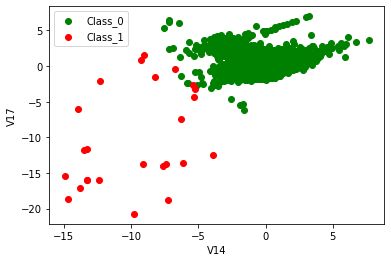

In [41]:
plt.scatter(valid_pred_df[valid_pred_df['Class']==0].V14, valid_pred_df[valid_pred_df['Class']==0].V17, color='green', label= 'Class_0')
plt.scatter(valid_pred_df[valid_pred_df['Class']==1].V14, valid_pred_df[valid_pred_df['Class']==1].V17, color='red', label= 'Class_1')
plt.xlabel('V14')
plt.ylabel('V17')
plt.legend()
plt.show()

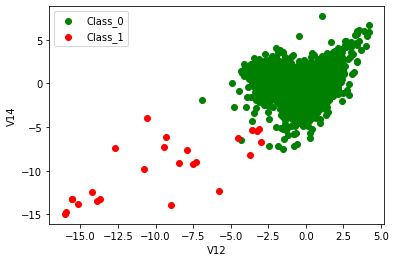

In [42]:
plt.scatter(valid_pred_df[valid_pred_df['Class']==0].V12, valid_pred_df[valid_pred_df['Class']==0].V14, color='green', label= 'Class_0')
plt.scatter(valid_pred_df[valid_pred_df['Class']==1].V12, valid_pred_df[valid_pred_df['Class']==1].V14, color='red', label= 'Class_1')
plt.xlabel('V12')
plt.ylabel('V14')
plt.legend()
plt.show()

## CV Stacking을 활용한 model 중 가장 좋은 성능을 나타낸 모델로 test data 예측 (개별 기반 모델: XGBoost, CatBoost 최종 메타 모델: LGBM)

In [31]:
print('CatBoost Mode 시작')
cat_train, cat_test = get_stacking_base_datasets(cat_clf, X_train, y_train, test_df, 10)
print('XGBoost Model 시작')
xgb_train, xgb_test = get_stacking_base_datasets(xgb_clf, X_train, y_train, test_df, 10)
stack_final_X_train = np.concatenate((cat_train, xgb_train), axis=1)
stack_final_X_test = np.concatenate((cat_test, xgb_test), axis=1)
print('원본 학습 피처 데이터 Shape', X_train.shape, '원본 테스트 피처 Shape', test_df.shape)
print('스태킹 학습 피처 데이터 Shape:', stack_final_X_train.shape)
print('스태킹 테스트 피처 데이터 Shape:', stack_final_X_test.shape)
lgbm_clf.fit(stack_final_X_train, y_train)
stack_final_pred = lgbm_clf.predict(stack_final_X_test)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
18:	learn: 0.1735368	total: 152ms	remaining: 7.86s
19:	learn: 0.1614248	total: 162ms	remaining: 7.93s
20:	learn: 0.1499082	total: 168ms	remaining: 7.85s
21:	learn: 0.1395659	total: 175ms	remaining: 7.78s
22:	learn: 0.1296842	total: 182ms	remaining: 7.73s
23:	learn: 0.1203341	total: 188ms	remaining: 7.66s
24:	learn: 0.1118686	total: 195ms	remaining: 7.61s
25:	learn: 0.1040787	total: 210ms	remaining: 7.88s
26:	learn: 0.0967355	total: 218ms	remaining: 7.84s
27:	learn: 0.0899435	total: 225ms	remaining: 7.8s
28:	learn: 0.0838186	total: 231ms	remaining: 7.74s
29:	learn: 0.0781538	total: 238ms	remaining: 7.68s
30:	learn: 0.0728609	total: 244ms	remaining: 7.63s
31:	learn: 0.0679222	total: 251ms	remaining: 7.58s
32:	learn: 0.0634236	total: 257ms	remaining: 7.54s
33:	learn: 0.0592727	total: 264ms	remaining: 7.49s
34:	learn: 0.0553423	total: 270ms	remaining: 7.45s
35:	learn: 0.0518036	total: 277ms	remaining: 7.41s
36:	learn: 0.0484967	total: 283ms	remaining: 7.

In [32]:
test_df = pd.read_csv('/content/drive/MyDrive/신입기수프로젝트/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, stack_final_pred.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [33]:
final_test_pred.to_csv('/content/drive/MyDrive/신입기수프로젝트/test_pred_best_stacking_ensemble.csv', index = False)